# SDV pipeline

SDV (Synthetic Data Vault) is a Python library (https://github.com/HDI-Project/SDV) that allows users to statistically model an entire multi-table, relational dataset. Users can then use the statistical model to generate a synthetic dataset. 

Underneath the hood it uses a unique hierarchical generative modeling method and recursive sampling techniques. Specifically, it fits a parametric models (Normal, uniform, etc) to each variable and uses a multivariate version of the Gaussian Copula to capture covariances between variables.

The library is designed to handle complete relational databases by sharing information between tables that have common keys.

The library has a function to automatically recognise the data types of each variable and choose a model accordingly but it does not work very well so it is safer if the user provides the necessary metadata in the form of a distionary.

In their paper (https://dai.lids.mit.edu/wp-content/uploads/2018/03/SDV.pdf), they describe an interesting experiment where they hired  DSs to analyse the original and synthetic data set to see how the results differ (which is a form of utility quantification).

There is one privacy feature that distorts values that the user characterises as private.

A first tes shows that the synthetic data might not always look like to original in terms of their distribution.

### Import libraries

In [1]:
import pandas as pd
from sdv import SDV
from sdv.evaluation import evaluate
%matplotlib inline

### Read the data

In [2]:
# Read a census data set from a website
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

columns = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income'
]

df = pd.read_csv(url, names=columns)

In [3]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Create metadata

In [4]:
# This is a list of the tables in the database 
tables = {
    'census': df
}

In [5]:
# This is a list of their variables and their data types in the form of dictionary - see docs for more details
metadata = {
    "tables": [
        {
            "fields": [
                {
                    "name": "age",
                    "type": "numerical",
                    "subtype": "integer",
                },
                {
                    "name": "workclass",
                    "type": "categorical",
                },
                {
                    "name": "fnlwgt",
                    "type": "numerical",
                    "subtype": "integer",
                },
                {
                    "name": "education",
                    "type": "categorical",
                },
                {
                    "name": "education-num",
                    "type": "numerical",
                    "subtype": "integer",
                },
                {
                    "name": "marital-status",
                    "type": "categorical",
                },
                {
                    "name": "occupation",
                    "type": "categorical",
                },
                {
                    "name": "relationship",
                    "type": "categorical",
                },
                {
                    "name": "race",
                    "type": "categorical",
                },
                {
                    "name": "sex",
                    "type": "categorical",
                },
                {
                    "name": "capital-gain",
                    "type": "numerical",
                    "subtype": "integer",
                },
                {
                    "name": "capital-loss",
                    "type": "numerical",
                    "subtype": "integer",
                },
                {
                    "name": "hours-per-week",
                    "type": "numerical",
                    "subtype": "integer",
                },
                {
                    "name": "native-country",
                    "type": "categorical",
                },
                {
                    "name": "income",
                    "type": "categorical",
                }
            ],
            "name": "census",
        }
    ]
}


### Fit the model

In [6]:
# Create an SDV object and fit the models to the data 
sdv = SDV()
sdv.fit(metadata, tables)

### Sample synthetic data

In [7]:
# Create a synthetic data set with equal number of rows as the original
samples = sdv.sample('census', num_rows=len(df))
samples['census'].head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,45,Local-gov,392773,11th,10,Married-civ-spouse,Machine-op-inspct,Not-in-family,White,Male,1696,112,37,United-States,>50K
1,3,Private,249377,Prof-school,7,Married-civ-spouse,Adm-clerical,Husband,White,Male,91,244,45,United-States,<=50K
2,47,Private,202259,HS-grad,12,Separated,Sales,Not-in-family,Black,Male,687,-360,22,United-States,<=50K
3,35,Private,183213,HS-grad,7,Married-civ-spouse,Adm-clerical,Not-in-family,White,Male,-692,567,55,United-States,<=50K
4,42,Private,-29743,HS-grad,12,Never-married,Adm-clerical,Not-in-family,White,Male,-2862,-184,35,United-States,<=50K


In [8]:
df.shape, samples['census'].shape

((32561, 15), (32561, 15))

### Utility metrics

In [9]:
# Use the evaluate function of the package to compare the original and synthetic data sets
# Unclear what it does exactly from the documentation - have to look at the code
evaluate(samples, real=tables, metadata=sdv.metadata)

,mse,r2_score,rmse
0,199668.53108,0.99945,446.842848


In [10]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [11]:
samples['census'].describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.518442,190249.885323,10.060625,1078.171985,83.545069,40.311784
std,13.573452,104089.059868,2.574375,2571.028389,398.434739,12.316833
min,-22.000000,-274603.000000,-2.000000,-9096.000000,-1560.000000,-12.000000
25%,29.000000,120220.000000,8.000000,-632.000000,-182.000000,32.000000
50%,39.000000,190056.000000,10.000000,1080.000000,87.000000,40.000000
75%,48.000000,260833.000000,12.000000,2819.000000,353.000000,49.000000
max,97.000000,620466.000000,21.000000,12271.000000,1646.000000,90.000000


In [12]:
# Histograms show that there are some discrepancies in frequencies - under investigation

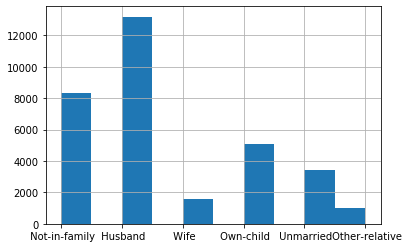

In [13]:
df['relationship'].hist()

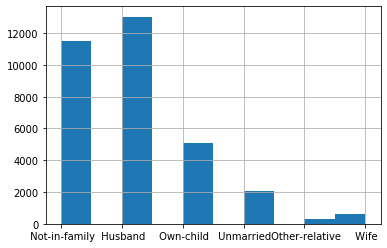

In [14]:
samples['census']['relationship'].hist()

### Synthesis on the ONS census data

In [17]:
df2 = pd.read_csv("../../datasets/rft-teaching-file/2011 Census Microdata Teaching File.csv", header=1)
df2.head()

,Person ID,Region,Residence Type,Family Composition,Population Base,Sex,Age,Marital Status,Student,Country of Birth,Health,Ethnic Group,Religion,Economic Activity,Occupation,Industry,Hours worked per week,Approximated Social Grade
0,7394816,E12000001,H,2,1,2,6,2,2,1,2,1,2,5,8,2,-9,4
1,7394745,E12000001,H,5,1,1,4,1,2,1,1,1,2,1,8,6,4,3
2,7395066,E12000001,H,3,1,2,4,1,2,1,1,1,1,1,6,11,3,4
3,7395329,E12000001,H,3,1,2,2,1,2,1,2,1,2,1,7,7,3,2
4,7394712,E12000001,H,3,1,1,5,4,2,1,1,1,2,1,1,4,3,2


In [18]:
metadata2 = {
    "tables": [
        {
            "fields": [
                {
                    "name": "Marital Status",
                    "type": "categorical"
                },
                {
                    "name": "Sex",
                    "type": "categorical"                    
                },
                {
                    "name": "Hours worked per week",
                    "type": "numerical",
                    "subtype": "integer",
                },
                {
                    "name": "Region",
                    "type": "categorical"
                },
            ],
            "name": "census"
        }
    ]
}

In [19]:
tables2 = {
    'census': df2
}

In [20]:
sdv2 = SDV()
sdv2.fit(metadata2, tables2)


In [21]:
samples2 = sdv2.sample_all(len(df2))
synth = samples2['census']

In [22]:
# Again we see discrepancies in the frequencies

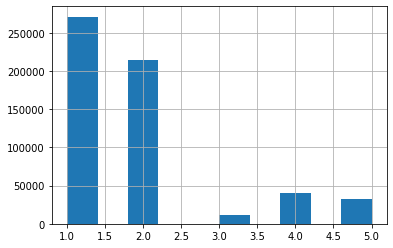

In [23]:
df2['Marital Status'].hist()

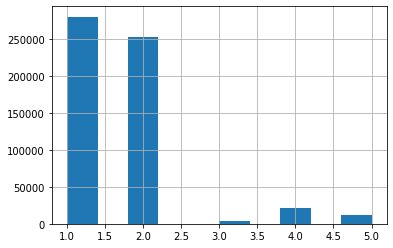

In [24]:
synth['Marital Status'].hist()